In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *

# Enforcing the speed limit replication notebook

In [2]:
NRUNS = 1

In [3]:
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 1,
    "ticks": 1000,
    "fundamental_value": 10,
    "lft_sample_size": 0.2,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_price": 0.01,
    "std_LFT_vol": 4,
    "std_HFT_vol": 4,
    "return_on_investment": 0.5,
    "investment_frequency": 5000,
    # lft parameters
    "w_fundamentalists": 1, #1
    "w_chartists": 1.4, # 10
    "w_random": 3,
    "spread_max": 0.5,
    # hft parameters
    "inventory_target": 1,
    "minimum_price_increment": 0.001,
    "investment_fraction": 0.00,
    "hfm_risk_aversion": 25,
    "hfm_fixed_vol": 1,
    # initial values
    "wealth": 300,
    "horizon_min": 1,
    "horizon_max": 4,
    "av_return_interval_max": 4,
    "init_price": 1,
    "agent_order_price_variability": (1, 1),
    "total_hft_money": 20000,
    "hft_speed": 1,
    "hft_init_investment": 0
}

# Initialisation

In [4]:
# 1 initalise model objects
high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)

# Simulation

In [5]:
for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
    high_frequency_traders, low_frequency_traders, orderbook = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)

0.760007623615
0.0932386572693
1.45184806619
-3.41414430248
0.940891904176
0.853498877219
1.55761401966
0.923882945056
1.53336854218
3.98278209073
1.00346692298
1.00346692298
0.10120451153
0.849221802645
0.386202149591
0.386202149591
0.930158630866
0.578906397705
0.200680843346
0.291096795619
1.87350049577
3.27768185153
1.09335614978
1.76598239689
-2.68108883149
0.0616733508369
0.0616733508369
0.0616733508369
3.00975534466
2.81522599212
0.611394040571
0.349746991145
0.349746991145
2.520501686
1.97706954387
0.689526304052
0.301044818315
0.828048550293
-3.59817021498
-3.59817021498
-3.59817021498
0.541791692688
-2.07016202036
0.113351299046
0.113351299046
0.517036276956
-0.212144768181
0.524879981075
0.524879981075
0.524879981075
0.195938044976
0.195938044976
2.55328141731
0.361291180835
0.0116934717278
0.239171511293
0.590709525944
1.07677677883
0.313797063376
2.40426497605
0.379632627497
0.464535440174
0.43622075925
-4.22559948914
0.834137983913
0.0101686035432
2.14899712662
1.82908238

# Data analysis

In [6]:
average_tick_price = [np.mean(prices) for prices in orderbook.transaction_prices_history]
total_tick_volume = [sum(volumes) for volumes in orderbook.transaction_volumes_history]
returns = pd.Series(np.array(average_tick_price)).pct_change()
autocorr_returns = [pd.Series(returns).autocorr(lag=lag) for lag in range(25)]
absolute_returns = pd.Series(returns).abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]

## Prices, returns & volume

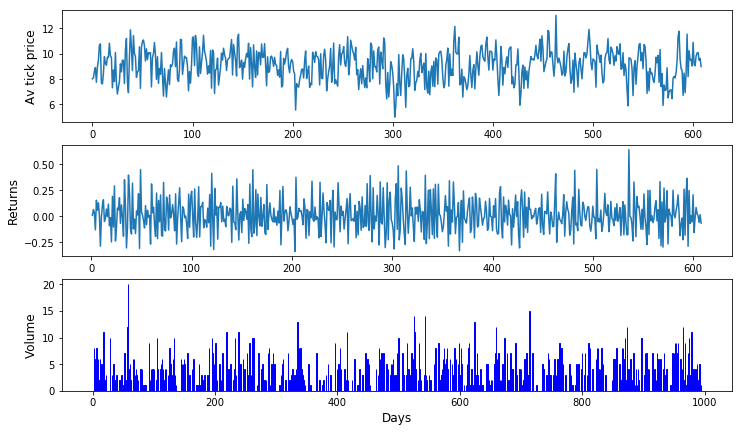

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,7))

ax1.plot(range(len(average_tick_price)), average_tick_price)
ax1.set_ylabel('Av tick price', fontsize='12')

ax2.plot(range(len(returns)), returns)
ax2.set_ylabel('Returns', fontsize='12')

ax3.bar(range(len(total_tick_volume)), total_tick_volume, edgecolor='b')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Days', fontsize='12')

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

## Bid-ask spread & volatility

In [8]:
bid_ask = [ask - bid for bid, ask in zip(orderbook.highest_bid_price_history, orderbook.lowest_ask_price_history)]
bid_ask = list(filter(lambda x: x >0, bid_ask))
np.mean(bid_ask)

1.5427875546816585

In [9]:
# is this the correct way 
window = 10
roller_returns = returns.rolling(window)
returns_volatility = roller_returns.std(ddof=0)
returns.std()

0.16355486289239615

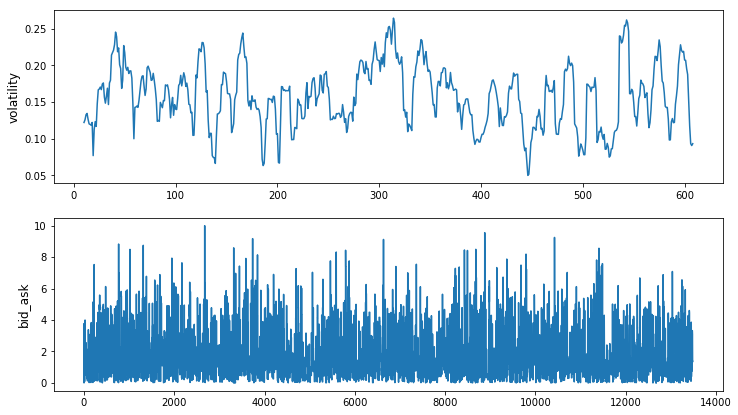

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))

ax1.plot(range(len(returns_volatility)), returns_volatility)
ax1.set_ylabel('volatility', fontsize='12')

ax2.plot(range(len(bid_ask)), bid_ask)
ax2.set_ylabel('bid_ask', fontsize='12')

# Basic financial market stylized facts
## No autocorrelation in returns

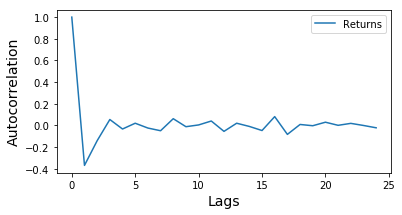

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.plot(range(len(autocorr_returns)), autocorr_returns, label='Returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
#fig.savefig('auto_correlation.png')

## Kurtosis

In [12]:
pd.Series(returns).kurtosis()

0.051870218242919819

## Clustered volatility

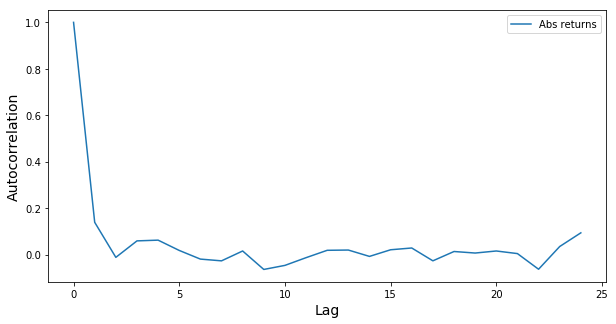

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns, label='Abs returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# HFT Investment

In [14]:
cum_inv = []
for hft in high_frequency_traders:
    cum_inv.append(np.array(hft.var_previous.cum_investment))

In [15]:
agg_cum_inv = np.zeros(len(cum_inv[0]))
for c_i in cum_inv:
    agg_cum_inv += c_i

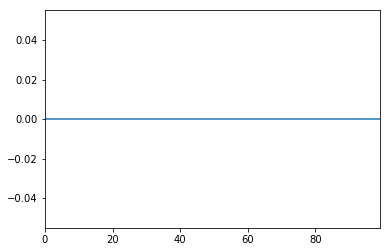

In [16]:
pd.Series(agg_cum_inv)[:100].plot()

# HFT speed

In [17]:
speed = []
for hft in high_frequency_traders:
    speed.append(np.array(hft.var_previous.speed))

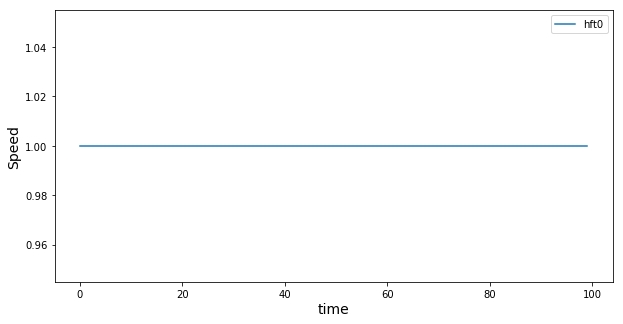

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, s in enumerate(speed):
    ax1.plot(range(len(s[:100])), s[:100], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Speed', fontsize='14')
ax1.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# HFT profitability

Total wealth. The HFT's track their own total wealth

In [19]:
money = []
stocks = []
locked_in_profits = []
for hft in high_frequency_traders:
    money.append(np.array(hft.var_previous.money))
    stocks.append(np.array(hft.var_previous.stocks))
    locked_in_profits.append(np.array(hft.var_previous.locked_profit))

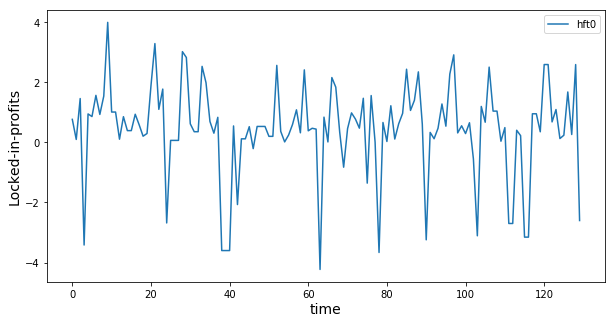

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, p in enumerate(locked_in_profits):
    ax1.plot(range(len(p)), p, label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Locked-in-profits', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

In [21]:
sum(locked_in_profits[0])

54.58811999590035

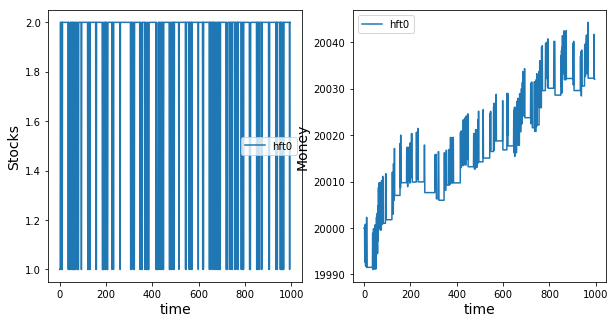

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

timeframe = 10000

for idx, s in enumerate(stocks):
    ax1.plot(range(len(s[:timeframe])), s[:timeframe], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Stocks', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

for idx, m in enumerate(money):
    ax2.plot(range(len(m[:timeframe])), m[:timeframe], label='hft{}'.format(idx))

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax2.set_ylabel('Money', fontsize='14')
ax2.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# Orderbook depth

size of ask book? Size of bids book?

In [24]:
np.random.normal(scale=parameters['std_LFT_price'])

0.004313224404561005

# Percentage of trades by HFT vs. LFT? 